In [1]:
# google drive
from google.colab import drive
drive.mount('/content/drive')
dirpath = "/content/drive/MyDrive/5053/"

Mounted at /content/drive


In [82]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.manual_seed(0)
np.random.seed(0)

In [83]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


def process(path):
    """
    pre-processing TRI data
    for train set (1997-2020): 1.eliminate extreme values; 2. standardization
    for test set (2020-2022): rolling window standardization
    """
    df = pd.read_csv(path)
    tri = df.tri.values
    split_node = df[df['timestamp'].str.contains('2019')].index[-1]
    train = tri[:split_node+1]
    test = tri[split_node+1:]
    train = process_extreme_MAD(train).reshape(-1, 1)
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = rolling_standard(train.ravel(), test)
    return train, test
    
    
def process_extreme_MAD(array, n=3):
    """
    Deal with extreme values, use MAD method
    """
    mid = np.median(array)
    mid1 = np.median(np.abs(array - mid))
    maximum = mid + n * mid1
    minimum = mid - n * mid1
    return np.clip(array, minimum, maximum)
    

def rolling_standard(pre, cur, n=60):
    """
    rolling window standardization
    """
    new = np.concatenate([pre[-(n-1):], cur])
    df = pd.DataFrame(new)
    mean = df.rolling(n).apply(np.mean)
    std = df.rolling(n).apply(np.std)
    df1 = (df - mean) / std
    return df1[(n-1):].values

In [84]:
calculate_loss_over_all_values = False
input_window = 45
output_window = 5
batch_size = 20 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)

def get_batch(d,i,num):
    """用于获得每个批次合理大小的源数据和目标数据.
       参数source是通过batchify得到的train_data/val_data/test_data.
       i是具体的批次次数.
    """

    # 首先我们确定句子长度, 它将是在bptt和len(source) - 1 - i中最小值
    # 实质上, 前面的批次中都会是bptt的值, 只不过最后一个批次中, 句子长度
    # 可能不够bptt的35个, 因此会变为len(source) - 1 - i的值.
    seq_len = num

    # 语言模型训练的源数据的第i批数据将是batchify的结果的切片[i:i+seq_len]

    train0 = d[i:i+seq_len]


    # 根据语言模型训练的语料规定, 它的目标数据是源数据向后移动一位
    # 因为最后目标数据的切片会越界, 因此使用view(-1)来保证形状正常.

    test0 = d[i+1:i+1+seq_len]
    return train0,test0


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
 
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        # pe.shape == [max_len, 1, d_model]
 
    def forward(self, x):
#         self.pe = self.pe.expand(-1, batch_size, -1)
        x = x.expand(-1, -1, 512) + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransAm(nn.Module):
    def __init__(self, feature_size=512, num_layers=1, dropout=0):  # feature_size 表示特征维度（必须是head的整数倍）, num_layers 表示 Encoder_layer 的层数， dropout 用于防止过你和
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size,0)  #位置编码前要做归一化，否则捕获不到位置信息
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=8,dim_feedforward = 64, dropout=dropout)  # 这里用了八个头
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, 1)  # 这里用全连接层代替了decoder， 其实也可以加一下Transformer的decoder试一下效果
        self.init_weights()
    def init_weights(self):  
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
#         if self.src_key_padding_mask is None:
#             mask_key = src_padding.bool()
#             self.src_key_padding_mask = mask_key
        # (10,1,1)
        src = self.pos_encoder(src)
        # (10,1,512)
        src = src.transpose(0,1)
        # (1,10,512)
        output = self.transformer_encoder(src, src_key_padding_mask=self.src_mask)  
        # (1,10,512)
        # output = self.decoder(output).view(10,-1)
        output = self.decoder(output)
        # (1,10,1)
        return output

cuda


In [85]:
class MyTransformer:
  def __init__(self):
    self.device = device
    self.model = TransAm()
    self.model = self.model.to(device)
    self.criterion = nn.MSELoss()
    self.lr = 0.00000001  # 学习率最好设置的小一些，太大的话loss会出现nan的情况
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 3, gamma=0.96)

  def preprocess(self, path):
    train_np, test_np = process(path)
    train_np = train_np.reshape(-1)
    test_np = test_np.reshape(-1)

    self.train_set = torch.from_numpy(train_np).float().to(self.device)
    self.test_set = torch.from_numpy(test_np).float().to(self.device)
    self.train_np, self.test_np = train_np, test_np
  
  def train(self):
    self.model.train()  # Turn on the train mode

    num_epochs = 10
    len_train = self.train_set.shape[0]
    len_step = 1
    len_batch = 10

    for epoch in range(num_epochs):
      total_loss = 0.
      start_time = time.time()

      # i+1+10 < len_train
      for batch, i in enumerate(range(0, len_train-1-10, len_step)):
          X, y = get_batch(self.train_set, i, len_batch)
          X = X.reshape(-1, 1, 1)
          
          self.optimizer.zero_grad()

          output = self.model(X)
          loss = self.criterion(output.view(-1), y)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
          self.optimizer.step()

          total_loss += loss.item()
      
      print(f"epoch {epoch}, total_loss = {total_loss}")

  def test(self):
    self.model.eval()

    len_test = self.test_set.shape[0]
    predictions = []
    for i in range(0, len_test-1):
      X, y = get_batch(self.train_set, i, 10)
      X = X.reshape(-1, 1, 1)

      output = self.model(X)
      output = output.view(-1)
      output = output.detach().cpu().numpy()
      predictions.append(output[0])
    
    self.pred = np.array(predictions)

In [86]:
transformer = MyTransformer()
print(transformer.device)
print(next(transformer.model.parameters()).device)

cuda
cuda:0


In [87]:
transformer.preprocess(dirpath + 'AUD_v2.csv')
print(transformer.train_set.shape)
print(transformer.test_set.shape)

torch.Size([5945])
torch.Size([556])


In [88]:
transformer.train()

epoch 0, total_loss = 14656.76519793272
epoch 1, total_loss = 3238.689144074917
epoch 2, total_loss = 1183.3067346140742
epoch 3, total_loss = 631.6729150488973
epoch 4, total_loss = 310.8220061417669
epoch 5, total_loss = 155.64960687654093
epoch 6, total_loss = 102.5944653992774
epoch 7, total_loss = 90.52035443880595
epoch 8, total_loss = 84.03743449627655
epoch 9, total_loss = 78.35974701627856


In [89]:
transformer.test()

Test MSE: 3.6975079587589574


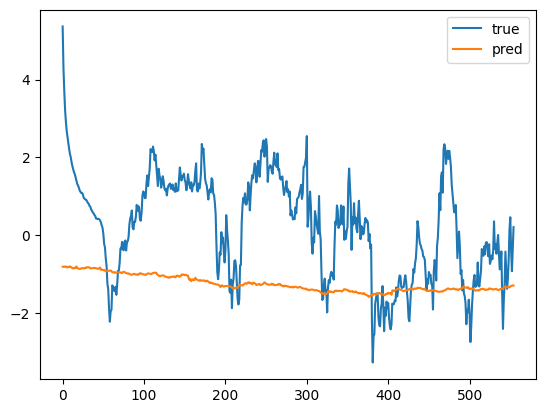

In [90]:
pred = transformer.pred
true = transformer.test_np[1:]
rmse=mean_squared_error(true,pred)
print("Test MSE:",rmse)
plt.plot(true)
plt.plot(pred)
plt.legend(['true','pred'])
plt.show()

In [91]:
a = pred
b = transformer.test_np[:-1]
c = np.diff(transformer.test_np)
out = np.logical_or(
      np.logical_and((b-a < 0),(c < 0)), 
      np.logical_and((b-a > 0),(c > 0))
    )

In [92]:
sum(out)/len(a)

0.44144144144144143